In [1]:
from pydub import AudioSegment
import numpy as np
import IPython
import matplotlib.pyplot as plt
import scipy, pylab
import scipy.ndimage
%matplotlib inline

### File Input

In [132]:
class Sound(object):
    def __init__(self, sound, framerate):
        self.sound = sound
        self.rate  = framerate
        
    @classmethod
    def from_audio_file(cls, path, start = 0, seconds = None):
        audiofile = AudioSegment.from_file(path)
        assert(audiofile.frame_rate == 44100)
        data = np.fromstring(audiofile._data, np.int16)
        
        if audiofile.channels == 2:
            channeled_music = data.reshape(len(data) / 2, 2).T

            left   = channeled_music[0]
            right  = channeled_music[1]

            mono = left#((left + right) / 2).astype(np.int16)
        else:
            assert audiofile.channels == 1
            mono = data
        if start != 0 or seconds is not None:
            if seconds is not None:
                segment = slice(
                    start * audiofile.frame_rate,
                    (start + seconds) * audiofile.frame_rate
                )
            else:
                segment = slice(
                    start * audiofile.frame_rate,
                    None
                )
            mono = mono[segment]
        return cls(mono, audiofile.frame_rate)
    
    @classmethod
    def from_spectrogram(cls, spectrogram, frame_seconds, frame_rate = 44100):
        # window used for fft
        frame_len = spectrogram.shape[1]
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        
        num_windows = spectrogram.shape[0]
        
        frame = 0
        data = np.zeros(num_windows * (frame_len))
        
        for t in range(0, spectrogram.shape[0] * (frame_len), (frame_len)):
            spectro = spectrogram[frame]#np.concatenate([spectrogram[frame], spectrogram[frame][::-1]])
            iffted = np.fft.ifft(spectro)
            iffted = np.real(iffted)
            iffted /= smoothing_window
            
            data[t:t+frame_len] = iffted
            frame += 1
            
        return Sound(data.astype(np.int16), frame_rate)
    
    def short_time_fft(self, frame_seconds):
        # window used for fft
        frame_len = int(self.rate * frame_seconds)
        if frame_len % 2 == 1:
            frame_len += 1
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        # store the frequencies inside big matrix
        num_windows = len(self.sound) // frame_len
        
        spectrogram = np.zeros((num_windows, frame_len), np.complex64)
        for frame in range(0, num_windows):
            t = frame * frame_len
            sample = self.sound[t:t+frame_len]
            ffted  = np.fft.fft(smoothing_window * sample)
            spectrogram[frame] = ffted
            
        return spectrogram
    
    def minibatch(self, tstep, length, overlap=0, normalize = False):
        assert(overlap < length)
        complex_batches = self.short_time_fft(tstep)
        print(complex_batches.real.shape)
        stacked = np.hstack([complex_batches.real, complex_batches.imag])
        print(stacked.shape)
        
        batch_size = length / tstep
        overlap_tstep = overlap / tstep
        num_batches = int(stacked.shape[0] / (batch_size-overlap_tstep))
        batches = np.empty((num_batches, batch_size, stacked.shape[1]))
        t = 0
        for batch in range(num_batches):
            batches[batch][0:min(stacked.shape[0] - t, batch_size)] = stacked[t:t+batch_size]
            #batches.append(stacked[t:t+batch_size])
            t += (batch_size - overlap_tstep)
            
        if normalize:
            batch_max = batches.max()
            batch_min = batches.min()
            batches = (((batches - batch_min) / (batch_max - batch_min)) * 2.0 - 1).astype(complex_batches.real.dtype)
            
        
        return batches
    
    def _repr_html_(self):
        return IPython.display.display_html(IPython.display.Audio(self.sound, rate=self.rate))

In [3]:
trumpets =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3", 21.5, 3)

In [4]:
begin =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3", 0, 3)

In [5]:
tstep = 0.02
Sound.from_spectrogram(begin.short_time_fft(tstep), tstep)

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

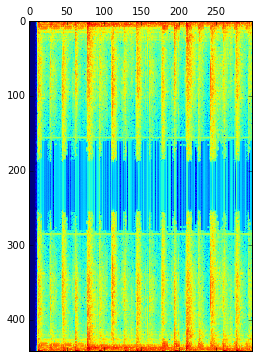

In [6]:
plt.matshow(np.log1p(np.abs(begin.short_time_fft(0.01).T)))

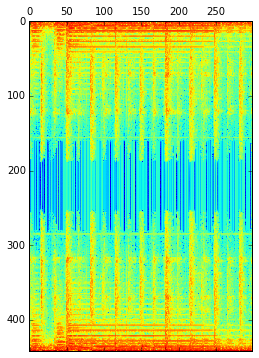

In [7]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)))

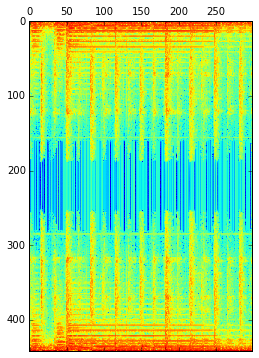

In [8]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)));

In [9]:
a = np.array([1., 5., 7.,10., 12., 5., 1., 0.2])

In [11]:
def overlap_sounds(sound1, sound2, zoom = 0.5, tstep = 0.01, mixing = 0.2):
    # undersample the sound to reduce computational load
    zoomed_sound1 = scipy.ndimage.zoom(sound1.sound, zoom)
    zoomed_sound2 = scipy.ndimage.zoom(sound2.sound, zoom)
    # find best overlap point
    offset = np.correlate(
       zoomed_sound1,
       zoomed_sound2,
       mode="same").argmax() / zoom
    offset = 0
    # cut sounds to right size to allow for overlap
    sound1_chopped = Sound(sound1.sound[:len(sound2.sound) - offset], sound1.rate)
    sound2_chopped = Sound(sound2.sound[offset:], sound2.rate)
    # mix the two sounds by mixing fourier transformed sound pieces
    # with mixing ratio
    mixed = ((sound1_chopped.short_time_fft(tstep)* mixing + sound2_chopped.short_time_fft(tstep) * (1.0 -mixing)))
    # rebuild new sound from spectrogram
    return Sound.from_spectrogram(mixed, tstep)

def overlap_sounds_subsample(sound1, sound2, subsampling = 5, tstep = 0.01, mixing = 0.2):
    # undersample the sound by listening to 1 / subsampling sound steps
    offset = np.correlate(sound1.sound[0::subsampling], sound2.sound[0::subsampling], mode="same").argmax() * subsampling
    # offseting
    sound2_chopped = Sound(sound2.sound[offset:], begin.rate)
    sound1_chopped = Sound(sound1.sound[:len(begin.sound) - offset], begin.rate)
    # mix the two sounds by mixing fourier transformed sound pieces
    # with mixing ratio
    begin_trumpets = ((sound1_chopped.short_time_fft(tstep) * mixing + sound2_chopped.short_time_fft(tstep) * (1.0 - mixing)) / 2.0)
    # rebuild new sound from spectrogram
    return Sound.from_spectrogram(begin_trumpets, tstep)

In [12]:
overlap_sounds(trumpets, begin, 0.2, 0.1, 0.2)

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBABp+pb6Bvy8/eb9F/32+0f7Bvxk/Tr+B/4r/KX5Ifn2+1j+vPxL+5387/yK+9n6CPxW/j3/1v25/EH+GwCh/4L+Cf8MASMC6QCO/0T/OP/z/44BiAIOAs0A6f+R/xf/af9vADUAZ/+Q/qf9Ov6//r79hP2a/tf/4v9D/mj9W/5w/xkATwBhAD4AKv9U/qz+GQCsAUsB2f/m/mv+yP5I/63/u/8C/03+uv1Y/gD/Gf7N/l0AQwD3/zcAGAJoBFcEAwMRAvkBSwL3AekBbgLuAZAAQwDmANYA3v/i/uL+5P6C/WP8c/ww/Dv7y/l7+I74Nvn0+HT4a/jB9yL2nfXq9sj33vYD9Tb0QPUK9kf1LfR59HX1GPWK9Iz0DPQj9Jz0qvR49Sn2fPWO9Hf07PRH9f/1SveQ9072AfW49OX1HfeN9o31HfXg9HP1V/Yd93/3mfYy9jf3BPd19cL0R/Vj9ob2DPWa9Jr1tvUf9UL1evaE91z3Hfeb93345vgq+C738/Y191P35fb/9Yr1IvaG9hj2XvZf9073K/YF9SH0KvS99Dj0PPMx85rzTfMs8l/xq/Hf8ofz6fJo8uTyE/QW9Z314/Xu9Uz2Tvb89aD2X/fY96f3m/ab9rD3Yfi19x33SPj0+HL4U/iz+EH5OvnU+Pf49fmY+r/5OPma+b36aPyW/F78lvx9/I39OP/+/wIAv//8/ywA2f+M/5r/EABDAN7/jP/L/3kARgHyAfcBUQETAWsBcgG2AZoCyQJ+Ai8CjAGsAa8CgQOmA38DCgTABDMF9AVbBjEGewZ+B4gIzgj1BwUHmgf6CLcJ1wl6CVAJuwloCiILHgv9CroLEAyZCzULbQqWCa0JqQlQCR0J0AgtCZQJGwkmCdMJHQraCUIJ7ghxCbcKdgu1C18MawzMC54LIAxnDasOGw8MDpUM+QwDDisO2w0qDRcNgA0hDfAMTQ11DS8NlQyMDOQM3QyeDAsMwwuMDB4NuAxKDC4MCQz0C+ELcgv/Co0KPgp/CrkK5grxCvEK3QsxDPsKRQo3CjIKiwrFCpYK4Qn/CMkItAgxCKMHRAc4B6oGLgV6BN8EQAW8BbcF7wTcBMEFOgYOBiwGXQa1BlkH6QYnBlQGeQZWBrUFGQWeBQcGtwVhBbcFpQZRBjwFPgV/BWgFBgVABM4DHQR9BEUEFAQwBEAElAS8BKkEzgSPBOUD/gLiARABVgDu/zUACQDf/pv9eP26/rH/ZP84/5j/wv+H/+v+rP4v/3n/T/82/zj/Cf+//t/+Vv/z/0gA8/+Y/2D/EP/t/r/+v/7W/l3+nv1W/ZD9xf2i/U/90fxJ/OX7NPv++Rf5pfiV+C/5MfmE+Mb4SPkT+Xn4Avge+EH4Jfhd+O34Mfn++B75Z/lE+SX5RvnP+aT6K/t1+/j78fzM/eH91v1P/iX/JQAzAQACWQJpAs0CagMYA14CUAIcApMB+wAQAJX/2/8AAKj/Z/+9/w0Avf+H/wYAlwC4AIQAKQBWAPkAPwEhAYcAxP+A/7H/IgBMAAQAEAAXAIr/Jf+A/ykAbwAXAKH/k/+R/1v/ef+q/8L/CwBdAMYAMwFNAVEBNgE2AZMBkAF7AaUBggFkAQ4BhwCeABkADP8M/wX/hf5P/sP9Iv3A/Cb8q/tz+0v72/oA+ln5P/mA+Wf5yvge+M/3PPg1+KX3F/gu+Kf3Avgn+D74nPhP+F34uPig+If4I/jt9474/viz+Dz4+fcE+EX4i/iq+JD4C/gG90n2XvZV9qT1LfXg9Bz0y/MM9Jrz6fL78jrzF/Og8n3yLPOj81/zJfMl82LzrPNY8xnzqvMf9BP0xvMz8zPzzfM/9Jz0dfQ49PX0nfWW9VX18PQY9Zj1rfW79bn1qPXZ9ZP1HfVs9fH1//UB9h/2yfUv9V71A/ZC9kL2U/Yr9qb1x/WE9rL24fY592/3Gfi6+DP5lflr+X752/kK+i/6Efoa+k36Jvpb+g/7cftO++f65/p1+wj8gfwL/Y39pf1x/Yv9uv3K/dP9uv3P/fL9J/4H/4r/Rv+R/z4AmQCzALoAAAEQAbMAfQBBAAQAHgD3/2v/Pf9k/zH/hf5t/nX/IADi/+7/iwACAS8BSwEOATcAuP8LAF8AJwDJ/1v/z/6//g7/r/5+/lT/lf8h/3z/ngDBASgCEQJnAvACYwPMAwoE1QS8BRkGIQcYCAMIYghJCb4J9gkWCmEKOQpgCU4JtwlzCWwJ1wnFCUkJFgmWCWgKwwqrCogKwAqJCzwMgAyoDNkMFw0VDdQM4AwsDZoNDA5gDjsOYg1UDTIOLw7eDbgNWw09DTENoQ1zDjIOow1UDcYM4AwqDYkMhwvjCj4LcguPCk4KmwoZCp0JLgrqCj4KRwnoCUUKNAnuCMcJwAkyCc4JZgqYCS0J7wlqCpIKOgu4C2ELGwuLC3QLpAopC3IMOgz9C4IMvwvjCs8LVA2cDXsMOAx0DEMLpAr/CoYKcQlNCBgI/AfkBrMGygZmBuQGsQaSBTcFNQVoBcUEeANcA/MC/AHSAYwBMwHiAEUA8//N/zUA2AAAAIf+F/7o/eb8GPyu/Ab9Evxq+zn7Qvub+3P7FvuD+lL6NPtg+xj7Vftu+9f7cfwL/ZD9qf32/Vv+Zv6F/tv+DP8c/zb/If8v/yj/E/98/3D/S/+H/4X/1P+x//7+Vv/N/63/4v8EAAsAggDfAAIB1ACzAFgBhQE/Ab8BxgHDAIQAnAEMAhABvABtAToB5/9P/9v/9f/1/7wA6QDp/3D/2//8/xAA0QCvAYkByAB2AHIAPwHbAjQD6QFUARwCswGXAC8BcAFaAGQAFQHX/wL+3f5aAJj/AP/X/4f/M/41/iX/RP8x//z/u//v/d39OP/p/tP9h/6o/4X+e/2o/nT+hvyU/Hj9oPz6+9r8Jf0f/B/8nv2s/d/8C/46/83+z/4wAHsAhf5m/qMAlwBi/4AAswGeAHn/mv86/9/9Nf0w/U78dfv4+4T81/s9+6b7XPt1+tD6c/sk++D6gfud+zb6sfnX+t76xPnZ+TT6MflR+LH47fgz+PL3i/g6+Iv3Lvjm+F34HPj5+Mr4BPjd+Iz5Gfjs9h74WPhj9mH2gvdl9g/1dfW29f70EfWr9bH04vJK8zL10vR080v0E/XE8wfzGPRu9JPzr/NU9FHz+/El8v/xQPFM8fvxa/LT8aTxgPLN8unyrPP18xDzPPOM9Db0X/N78wX0NvT888n0K/U/9Cb0r/Ti9GD0r/OM81TzkPLf8erxZvFZ8HPwEvGU8YbxD/H68JTwQPC58BnxMvHc8Z7ykvLK8pDzz/Ov8/zzNPX89Sb2xfeC+Vn59PiH+SH6+fnW+YP6Aftg+6v8hv3t/Hr8M/2l/S79kv26/jH/Uv/J/9sAFQL8AqYDjQOYA8UEpwWwBcUFCwYJBhkGaQbTBZYETgTqBDMFFwVtBVEFTARCBPgEwARcBF4EXgQPBLcDxQOKA1AD6ANcBCkEIgRzBEkEogN6A/8DVQQkBDsEjQRHBCsE/QQxBhAHnAfJB8sHVwi0CM4IbgkZCp0K9goXC/sKxwo+C5ILaAvMCx4M0QsODKgMKgwEC7kKSAv2CswJGQpYCucIpgiICcIJvgkwCvQKagpxCbkJPQnWB9sHHwmNCd4I9QgvCXAI0Ag5CjAK6ghnCLIIYggaCLIIsgjEB3kHxgc4B2kGEAcMCOQHOwi7CcoKlQscDWcOLw4VDfUMXQ2sDJMMnw2oDUENUg0DDUgM8gs4DKcLOQq+CQgKRwqZCg0L5groCf0J3AqNCmMKHguOC8gLMQzEDPAM1gx1DcQNjg1pDkcPtA7UDdANRw5XDlkOmA4MDncN/A0mDukMVgt/CvYJZQlZCT0JcAgsB1EGSAYQBrcFGQXHA80CaQKxApgCLAEgA

In [13]:
overlap_sounds_subsample(trumpets, begin)

<source src="data:audio/wav;base64,UklGRjjZAQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YRTZAQBxCYcICAjUCBoIUwa4BPUEzgX9BFkF0gUCBHwCGAIVA/MCh/8x/rf/I/+f/SH8Mvpv+nj7d/pC+ZD5NPn89h71l/UW+af6KveI9HLzJfMm9Wb2Zvbs9AXzMvSh9Gnyy/JU9Wn17/O/86H0efQq8mzwkPGW9P72MfZy8wXykvG18Qr0ZvZy9vj0LvLS8MHyW/aT+Mj29PQT9dTzbvE88eH0lvb09Ifz6/Ct8Q31RfQn86zzxvSZ9X71Xfh0+536QPnt+RT8vP0j/sD9U/4KAHsAcgIVBhwH+gZuBi4GoQeVCGwItQiPCpELBwo1ClEMTQwlC/UKtgoxCv8J7gnWCuMLjwvqChoKDQoMC3kJOQd/CK8J6wj1CPUHRAXeBNAFeQZMCCcIlQRJAW4A3AKFBSUGBweIB5oGTgSwAlYEMgamBTIDUAEDAvcChQO5A9kBaP9//8QA0P/k/en7/vlg+if7svq6+j363fdP9k/3pviY+TT5JPcK9kL2Mvd99tLznfJU8hryV/Gw74PuQu3y7PPtJO9X8FTva+3t7fvt4uzi7bfude4H8E/xzvBn8FPwbPBq8WPyw/Jr9WT3tvTt87r32vuL/vf+mf1F/dn/RgKeAkgCqAJ1BMMECQQHBSwG1wZsBncGLQgKCTgJxQhoCHEJrArWCx0MNgseCl0IZQcJCu8Nzw2qCtwI2Aj4CYcLCAwjC24IBwU9BDYGPwdrBDIAHv6s/aD+Cv9s/Bv5TfeH9oL1c/TS80TzlfJD8bnwV/Ef8azw3vCX8NzvSPB+8GHwavHO8F/wH/PU9aD2qvVp9Uz4z/qt+r/7s/6mABYCeAJAA+oGbwlOCt8LmwxlDWwOqQ7xEM4TORO+EToRwhKPFrUXhRZAFswWuhcuFxwWrhbqFwEZgRljGZgZNhqOGu0ZehjDGAEcyR7RHYUZPhY5GFIdlx6OGmoX7RY8F4YYlxjQFmMV0xTCFEAUbRLSEEkRFxI9EsIRMxCZDyQPLw5mD+IPXw1uC/sKegvIDFwM8wrSC2wOQhDEDh8MoQxEDtQOmQ+HEHwQ0w95D4YPzw81ENAQKRG/EBkPIg1ZDsMQgBCrD/oODA7CDlAQORCZD/APzw+wEJISexGzDkINPw0hDosNugqmCBQIIAdkBrwGbgVgAcn+jv9bALf/jf5z/dL7APrw+V76Efog+ov5IfmC+uD6Evn496L4Sflj+C321/RR9ib4kPdt95/44vjr+ef7nf2v/6AAiQC7AL0ANwGAAroEqgfVB7IEugQhCSsLbQrgCr8L9wpoCQQJowl8CvUKAQqTCEoImAjQCGIJBQrECUwIXgazBaUGXgfKBfMCywGLArkD5wKWACAB+QLEAZX+G/3T/f39qf3C/R7+Bv+5/nn9Z/0z/o7/0ADQAOH/1P7H/Vz9zf1E/jr/4P60+236Jv0AAFMA9/3s+s/6qfwE/Of5mfhm96v2WPVD9LL1avb09Mrzi/N99KH1Z/Xo9PD0Z/WU9rX2TPXq9Kb1nPa59k71gfbb+Xn5XvcX98D3e/lk+mT5DvnD+LT3VvjM+RP6Lvqx+V/49Pdy+Db5g/mw+AX4ZPeP9sT2H/fb9p726/ai+Nb5fvh999334vfB+Pr5nvnv+LL49/hX+RT4lvYC9/j3N/gc+Mb3E/f69lv4g/kE+Uz40vgy+en4DfpE+3j7WP04//X+3P46/1MANQJnAgUCEAPnAwkErwNjAtsBBAPKA5wD8QLCASACLgTHBPoDewP3Au0CVwPHAvIBCwKGAbz/0v4O/7v+Yf6X/s7+Yv+p/2D/wP95/xL+qf0y/Yn7F/qs+M333fdf9mT0dfTA9OP09vQI8yHxdfGr8c7wXfAl8D7utuoU6Hjn9ecO6LHmweTt4qfhnuJx5EHk4+K+4WfhhOGc4CPgguF44mriPOIU4gjjX+RK5NzkSOcs6erp5OlW6oXttfCK8T3yPvPZ9JT23faJ+BL7EvuA+zD9+/2e/14B9wFTA5IERgUcB1UICggKCLEI4QkDCnwHnAWcBnwHJgeHBj4FNQQoBCoEfwOdAQQA2f97/zb/Hf/8/ND5p/e79gv3F/dw9tr1evOL8K7wnPHQ8CfwEPDA7yzvre5c7v3s6+ub7fjupu0u7KnrGexO7RbtYux+7ULu6+0X7ofuDvAg8lTyEvOm9Zb2Nvac9kz4pPuQ/Rf9B/7A/6QAUAL4A7gEmwQTBM4FUQh/CLkIVQlMCLoH5whnCoQKuwh/CLgK5ApmCfwJ9Av3DXEPWg/0DrgP4hAGEfkP1Q8HEr0TSxJ+ENYQgxF+EgYUpBMqEigS0xKbEgASyRKgFCwVMhSyEg4RFBBlELURLBLgEJYP1A5wDsYOfw6LDZsNGw/FEFQQ+g7RD8MQvA8/D+YPLxCZEDoRFhDgDQIOxA/5D/sPgRFzEkcSSxJBEqQRYRCQDxYQew+NDcsMhQs0CSMJdgroCQwInAZTBX4EUATQAiMAy/35+137KPoI96X0fPMn80Lzq/HV7yDvbO5/7kLuX+147YrsQOsk7PvslOwE7DLsM+1X7bLtru8Q8Gzusu1w7fnsme0u73TwavGj8mPzXfPz8731s/ao9ar1jPd0+Ob4H/my+KT56fsn/un+X/5V/5YAHwASADIBbgICAxAChgHLApsCsAFrAj4CZQINBBcEIgQeBTcFngUKBswFRQapBsoGUgdeB1wHoQbkBEIFfwZVBm4GxwUNBFoE/AUfBvAEAgRrBIQELQIdAAgAPP+h/Rv8pfo2+hv6CPkf9y31YfUR9y32VvQy9C/z1fHA8QjxGvBs8NDwee/B7bHuGPDu7lfuuu9576nuxfAp8zXznfJ+8svyUfMC9K/0pfRB9e323vVj8+H0hPdi9yb3RvjQ+ej6p/pd+YT4g/mq+3D83fre+Bv5J/v7+1f82f38/Ob65/zd/9f/OP+Y//j/Zv97/4YBmwJZAjsEeAWbAvAANwKyAYX/p/32/Dz+hf5+/S3+YP1r+oT6Gfzj/Hf9FPur94z3Sfno+tf6bvme+eH5m/hj+LD4kfje+Er4KPhE+f342viS+RD5EPkG+mD6XfsS/I37b/0bAVkCrwDJ/nsAnAO+AywEvwVMBf8EJwbZBo4HMglfCusILgZ8B1ELGguQCaoKoQr5B/oFsQb1B08GxgMMA60BAACj/7T9Cftv+tP6wPpE+aP3SfcL98H25PVl81zxaPER8V7v9e1J7ATrPerj6Ajpd+lC6J/nLejt6B3ov+Wd5NHkx+Qv5arlLOSe4g7jNeQK5pHniOe+5r/l0+YD6mrr6+qi687tuu8K8fLx+fLx82b0PfVT9jn4ovvK/CL7Svu8/ZL/f/+k/mD/gAFJAxkEqwPHAnQCZQJdAiIC5AFOAvECmQKnAf8BbAMLBFEDLwIWAgQD1wOFA0QC1wGZAWYAkP/9/XT7rfpL+m/4ffce+Pj3YfYe9RH1WvQB8/jzX/Wg8x7y5vK48mfydvND9LH01fQT9R/2lPaF9iz37Pf3+Cv7b/1w/j7+5f6AAVkDzAOdBGkFqQYSCP8HRwciB/sHlAk3CmIJWQjRBzoIbAmxCcUIcQerBjwIxQhQBUMELAeDBicDXgPgBM8EowQkBOMDtAQyBtEHawd3BvkHowlBCQgIogiRCm8KVgrQC38LMQv9DMcN7Q3IDn8O/Q25DqUPThCdD30O7g/vEBkPCw+kEa4TkBSFFBcVUxdGGTAaxhlMGP0YVBriGHEYlhnDGO4X2xdeF8gXKBjhFsAUsBMeFecWvRYHFr4VJBX+FOgVzxVLFK4TnBNWErkQ0BAVEsARoBDUEEgQcw8fEUcSARAUDc4L7QpVCYUIMwhjBc0BHQFnAU3/svs0+Zv3Gvbm9XT27/VJ9CzyW/A+8K3xuvGp70Ttieso7Ejt+utO6

In [101]:
from theano_lstm import Layer, create_optimization_updates, random_initialization
import theano.tensor as T
import theano

def relu(x):
    return T.maximum(x, np.float32(0.0))

class Autoencoder(object):
    def __init__(self, input_size, hidden_sizes = None):
        self.layers = []
        sizes = [input_size] + hidden_sizes[:-1] + [hidden_sizes[-1]] + list(reversed(hidden_sizes[:-1])) + [input_size]
        self.sizes = sizes
        for in_size, out_size in zip(sizes[:-1], sizes[1:]):
            self.layers.append(Layer(in_size, out_size, relu))
            
        self.layers[-1].activation = T.tanh
        
        self.gsums = [None] * len(self.params)
        self.xsums = [None] * len(self.params)
        
    def activate(self, x):
        h = x
        for layer in self.layers:
            h = layer.activate(h)
        return h
    
    def error(self, x):
        out = self.activate(x)
        error = ((out - x) ** 2).sum() / x.shape[0]
        return error
        
    def create_predict_fun(self):
        x = T.matrix()
        self.predict_fun = theano.function([x], self.activate(x))
    
    def create_error_fun(self):
        x = T.matrix()
        self.error_fun = theano.function([x], self.error(x))
    
    def create_update_fun(self, **kwargs):
        x = T.matrix()
        error = self.error(x)
        updates, self.gsums, self.xsums, self.lr, self.max_norm = create_optimization_updates(
                error,
                self.params,
                **kwargs
        )
        self.update_fun = theano.function([x], outputs=error, updates=updates)
        
    def reset_weights(self):
        for gsum, xsum, param in zip(self.gsums, self.xsums, self.params):
            param.set_value(random_initialization((param.get_value(False, False).shape)))
            if gsum is not None:
                gsum.set_value(np.zeros_like(param.get_value(False, False)))
            if xsum is not None:
                xsum.set_value(np.zeros_like(param.get_value(False, False)))
    @property
    def params(self):
        return [param for layer in self.layers for param in layer.params]

In [116]:
sample_length = 1
sample_tstep = 0.01
spectral_size = 884
input_size = int(sample_length / sample_tstep) * spectral_size
a = Autoencoder(input_size, [250, 100])
a.create_predict_fun()
a.create_error_fun()
a.create_update_fun(method="adagrad", lr=0.005, eps = 1e-6)

In [134]:
fullsong =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3")

In [135]:
fullsong.minibatch(tstep = sample_tstep, length = sample_length, overlap = 0.5, normalize=True)

(22575, 442)
(22575, 884)


array([[[ 0.00842956,  0.00842956,  0.00842956, ...,  0.00842956,
          0.00842956,  0.00842956],
        [ 0.00842956,  0.00842956,  0.00842956, ...,  0.00842956,
          0.00842956,  0.00842956],
        [ 0.00842956,  0.00842956,  0.00842956, ...,  0.00842956,
          0.00842956,  0.00842956],
        ..., 
        [ 0.11584164, -0.09665992,  0.02191808, ...,  0.02428786,
          0.00329217, -0.0680436 ],
        [ 0.03711574, -0.01174765,  0.02606913, ..., -0.00201137,
          0.01153616, -0.0780744 ],
        [ 0.01822093, -0.00801575,  0.01950605, ...,  0.03167121,
          0.01633731, -0.00948519]],

       [[-0.04761896,  0.00451248,  0.07357812, ..., -0.0125381 ,
          0.03760297, -0.00134116],
        [ 0.10246726, -0.04369287, -0.02156252, ..., -0.01269329,
          0.07578999, -0.0600564 ],
        [ 0.06831955, -0.00842434, -0.00254651, ...,  0.03110375,
         -0.03546407,  0.04369596],
        ..., 
        [ 0.03821017, -0.01132549,  0.02610859, ...,

In [73]:
batches = fullsong.minibatch(tstep = sample_tstep, length = sample_length, overlap = 0.5, normalize=True)

In [90]:
a.lr.set_value(0.1)

In [91]:
a.reset_weights()

In [117]:
batch_size = 10
adadelta = []
for i in range(1000):
    epoch_error = 0.0
    for subbatch in range(batches.shape[0] // batch_size):
        error = a.update_fun(batches[subbatch * batch_size :subbatch * batch_size + batch_size].reshape(batches[subbatch * batch_size:subbatch * batch_size + batch_size].shape[0], batches.shape[1] * batches.shape[2]))
        epoch_error += error
        print("   error = ", error, flush=True)
        sys.stdout.flush()
    
    print("epoch_error => ", epoch_error, flush=True)
    sys.stdout.flush()
    adadelta.append(epoch_error)

   error =  17.249488830566406
   error =  11.367921829223633
   error =  33.804500579833984
   error =  35.91899108886719
   error =  40.543609619140625
   error =  43.62459945678711
   error =  41.482479095458984
   error =  44.00851058959961
   error =  37.3265495300293
   error =  40.05280303955078
   error =  43.28020477294922
   error =  45.394020080566406
   error =  45.07255554199219
   error =  43.978023529052734
   error =  39.01121520996094
   error =  32.45822525024414
   error =  33.98028564453125
   error =  43.09870910644531
   error =  40.10554122924805
   error =  35.721824645996094
   error =  37.241336822509766
   error =  48.54365158081055
   error =  42.79976272583008
   error =  51.448020935058594
   error =  41.53023147583008
   error =  47.49441909790039
   error =  41.552696228027344
   error =  47.32892608642578
   error =  44.81467819213867
   error =  47.2356071472168
   error =  47.980384826660156
   error =  43.74782180786133
   error =  44.45290756225586


KeyboardInterrupt: 

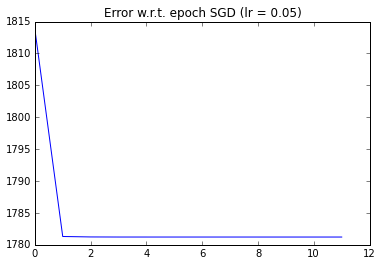

In [89]:
plt.plot(sgd_errors)
plt.title("Error w.r.t. epoch SGD (lr = 0.05)");

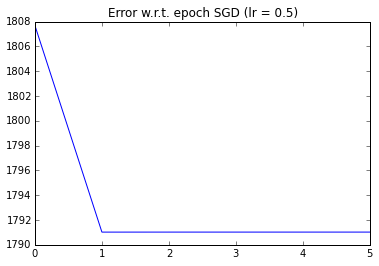

In [93]:
plt.plot(sgd_fast)
plt.title("Error w.r.t. epoch SGD (lr = 0.5)");

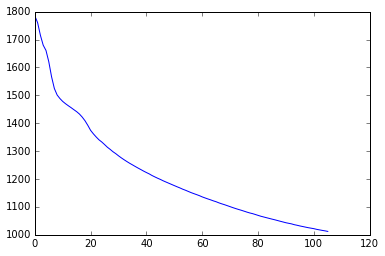

In [240]:
plt.plot(adadelta)

In [182]:
sample = batches[0]

In [196]:
max_fullsong = max(fullsong.short_time_fft(tstep).real.max(), fullsong.short_time_fft(tstep).imag.max())
min_fullsong = min(fullsong.short_time_fft(tstep).real.min(), fullsong.short_time_fft(tstep).imag.min())

In [221]:
def convert_sample_to_sound(sample, tstep, length,
                            attenuate_above=None,
                            attenuate_below=None):
    window_len = int(length / tstep)
    spec_size = int(sample.size / window_len)
    frate = 44100
    
    sample = sample.reshape((window_len, spec_size))
    sample = sample * (max_fullsong - min_fullsong)
    
    reals = sample[:, :spec_size // 2]
    imags = sample[:, spec_size // 2:]
    complexs = np.empty_like(reals, dtype=np.complex64)
    complexs.real = reals
    complexs.imag = imags
    
    if attenuate_above is not None or attenuate_below is not None:
        attenuate_below = 0 if attenuate_below is None else attenuate_below
        attenuate_above = frate if attenuate_below is None else attenuate_above
        for i in range(complexs.shape[1]):
            freq = (i * frate / (complexs.shape[1]))
            if not(attenuate_below <= freq and freq <= attenuate_above):
                complexs[:,i] = 0.
    
    
    return complexs

In [238]:
Sound.from_spectrogram(
    convert_sample_to_sound(
        sample,
        sample_tstep,
        sample_length,
        attenuate_above = 45000,
        attenuate_below = 90),
    sample_tstep)

<source src="data:audio/wav;base64,UklGRnRZAQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YVBZAQA49RryIPIr8jnyS/Jh8nvymPK58tzyA/Ms81fzhfO08+XzGPRM9IH0tvTt9CP1WvWR9cj1//U29mz2ofbW9gr3Pvdw96L30vcC+DH4X/iM+Lf44vgM+TT5XPmC+aj5zPnw+RL6NPpV+nT6k/qx+s766/oG+yH7O/tU+237hPuc+7L7yPvd+/L7BvwZ/Cz8PvxQ/GH8cvyC/JL8ovyx/L/8zvzb/On89vwD/Q/9G/0n/TL9Pf1I/VP9Xf1n/XH9ev2E/Y39lf2e/ab9r/23/b79xv3N/dT92/3i/en97/32/fz9Av4I/g7+E/4Z/h7+JP4p/i7+M/43/jz+Qf5F/kn+Tv5S/lb+Wv5e/mL+Zf5p/mz+cP5z/nf+ev59/oD+g/6G/on+jP6P/pH+lP6W/pn+m/6e/qD+o/6l/qf+qf6r/q3+r/6x/rP+tf63/rj+uv68/r3+v/7B/sL+xP7F/sb+yP7J/sr+zP7N/s7+z/7Q/tH+0v7T/tT+1f7W/tf+2P7Z/tn+2v7b/tz+3P7d/t3+3v7f/t/+4P7g/uD+4f7h/uL+4v7i/uL+4/7j/uP+4/7j/uT+5P7k/uT+5P7k/uT+5P7j/uP+4/7j/uP+4v7i/uL+4v7h/uH+4P7g/uD+3/7f/t7+3f7d/tz+3P7b/tr+2f7Z/tj+1/7W/tX+1P7T/tL+0f7Q/s/+zv7N/sz+yv7J/sj+xv7F/sT+wv7B/r/+vf68/rr+uP63/rX+s/6x/q/+rf6r/qn+p/6l/qP+oP6e/pv+mf6W/pT+kf6P/oz+if6G/oP+gP59/nr+d/5z/nD+bP5p/mX+Yv5e/lr+Vv5S/k7+Sf5F/kH+PP43/jP+Lv4p/iT+Hv4Z/hP+Dv4I/gL+/P32/e/96f3i/dv91P3N/cb9vv23/a/9pv2e/ZX9jf2E/Xr9cf1n/V39U/1I/T39Mv0n/Rv9D/0D/fb86fzb/M78v/yx/KL8kvyC/HL8YfxQ/D78LPwZ/Ab88vvd+8j7svuc+4T7bftU+zv7IfsG++v6zvqx+pP6dPpV+jT6Evrw+cz5qPmC+Vz5NPkM+eL4t/iM+F/4MfgC+NL3ovdw9z73CvfW9qH2bPY29v/1yPWR9Vr1I/Xt9Lb0gfRM9Bj05fO084XzV/Ms8wPz3PK58pjye/Jh8kvyOfIr8iDyGvIY8jj1GvIg8ivyOfJL8mHye/KY8rny3PID8yzzV/OF87Tz5fMY9Ez0gfS29O30I/Va9ZH1yPX/9Tb2bPah9tb2Cvc+93D3ovfS9wL4Mfhf+Iz4t/ji+Az5NPlc+YL5qPnM+fD5Evo0+lX6dPqT+rH6zvrr+gb7Ifs7+1T7bfuE+5z7svvI+9378vsG/Bn8LPw+/FD8Yfxy/IL8kvyi/LH8v/zO/Nv86fz2/AP9D/0b/Sf9Mv09/Uj9U/1d/Wf9cf16/YT9jf2V/Z79pv2v/bf9vv3G/c391P3b/eL96f3v/fb9/P0C/gj+Dv4T/hn+Hv4k/in+Lv4z/jf+PP5B/kX+Sf5O/lL+Vv5a/l7+Yv5l/mn+bP5w/nP+d/56/n3+gP6D/ob+if6M/o/+kf6U/pb+mf6b/p7+oP6j/qX+p/6p/qv+rf6v/rH+s/61/rf+uP66/rz+vf6//sH+wv7E/sX+xv7I/sn+yv7M/s3+zv7P/tD+0f7S/tP+1P7V/tb+1/7Y/tn+2f7a/tv+3P7c/t3+3f7e/t/+3/7g/uD+4P7h/uH+4v7i/uL+4v7j/uP+4/7j/uP+5P7k/uT+5P7k/uT+5P7k/uP+4/7j/uP+4/7i/uL+4v7i/uH+4f7g/uD+4P7f/t/+3v7d/t3+3P7c/tv+2v7Z/tn+2P7X/tb+1f7U/tP+0v7R/tD+z/7O/s3+zP7K/sn+yP7G/sX+xP7C/sH+v/69/rz+uv64/rf+tf6z/rH+r/6t/qv+qf6n/qX+o/6g/p7+m/6Z/pb+lP6R/o/+jP6J/ob+g/6A/n3+ev53/nP+cP5s/mn+Zf5i/l7+Wv5W/lL+Tv5J/kX+Qf48/jf+M/4u/in+JP4e/hn+E/4O/gj+Av78/fb97/3p/eL92/3U/c39xv2+/bf9r/2m/Z79lf2N/YT9ev1x/Wf9Xf1T/Uj9Pf0y/Sf9G/0P/QP99vzp/Nv8zvy//LH8ovyS/IL8cvxh/FD8Pvws/Bn8Bvzy+937yPuy+5z7hPtt+1T7O/sh+wb76/rO+rH6k/p0+lX6NPoS+vD5zPmo+YL5XPk0+Qz54vi3+Iz4X/gx+AL40vei93D3PvcK99b2ofZs9jb2//XI9ZH1WvUj9e30tvSB9Ez0GPTl87TzhfNX8yzzA/Pc8rnymPJ78mHyS/I58ivyIPIa8hjyOPUa8iDyK/I58kvyYfJ78pjyufLc8gPzLPNX84XztPPl8xj0TPSB9Lb07fQj9Vr1kfXI9f/1NvZs9qH21vYK9z73cPei99L3Avgx+F/4jPi3+OL4DPk0+Vz5gvmo+cz58PkS+jT6Vfp0+pP6sfrO+uv6Bvsh+zv7VPtt+4T7nPuy+8j73fvy+wb8Gfws/D78UPxh/HL8gvyS/KL8sfy//M782/zp/Pb8A/0P/Rv9J/0y/T39SP1T/V39Z/1x/Xr9hP2N/ZX9nv2m/a/9t/2+/cb9zf3U/dv94v3p/e/99v38/QL+CP4O/hP+Gf4e/iT+Kf4u/jP+N/48/kH+Rf5J/k7+Uv5W/lr+Xv5i/mX+af5s/nD+c/53/nr+ff6A/oP+hv6J/oz+j/6R/pT+lv6Z/pv+nv6g/qP+pf6n/qn+q/6t/q/+sf6z/rX+t/64/rr+vP69/r/+wf7C/sT+xf7G/sj+yf7K/sz+zf7O/s/+0P7R/tL+0/7U/tX+1v7X/tj+2f7Z/tr+2/7c/tz+3f7d/t7+3/7f/uD+4P7g/uH+4f7i/uL+4v7i/uP+4/7j/uP+4/7k/uT+5P7k/uT+5P7k/uT+4/7j/uP+4/7j/uL+4v7i/uL+4f7h/uD+4P7g/t/+3/7e/t3+3f7c/tz+2/7a/tn+2f7Y/tf+1v7V/tT+0/7S/tH+0P7P/s7+zf7M/sr+yf7I/sb+xf7E/sL+wf6//r3+vP66/rj+t/61/rP+sf6v/q3+q/6p/qf+pf6j/qD+nv6b/pn+lv6U/pH+j/6M/on+hv6D/oD+ff56/nf+c/5w/mz+af5l/mL+Xv5a/lb+Uv5O/kn+Rf5B/jz+N/4z/i7+Kf4k/h7+Gf4T/g7+CP4C/vz99v3v/en94v3b/dT9zf3G/b79t/2v/ab9nv2V/Y39hP16/XH9Z/1d/VP9SP09/TL9J/0b/Q/9A/32/On82/zO/L/8sfyi/JL8gvxy/GH8UPw+/Cz8GfwG/PL73fvI+7L7nPuE+237VPs7+yH7Bvvr+s76sfqT+nT6Vfo0+hL68PnM+aj5gvlc+TT5DPni+Lf4jPhf+DH4AvjS96L3cPc+9wr31vah9mz2Nvb/9cj1kfVa9SP17fS29IH0TPQY9OXztPOF81fzLPMD89zyufKY8nvyYfJL8jnyK/Ig8hryGPI49RryIPIr8jnyS/Jh8nvymPK58tzyA/Ms81fzhfO08+XzGPRM9IH0tvTt9CP1WvWR9cj1//U29mz2ofbW9gr3Pvdw96L30vcC+DH4X/iM+Lf44vgM+TT5XPmC+aj5zPnw+RL6NPpV+nT6k/qx+s766/oG+yH7O/tU+237hPuc+7L7yPvd+/L7BvwZ/Cz8PvxQ/GH8cvyC/JL8ovyx/L/8zvzb/On89vwD/Q/9G/0n/TL9Pf1I/VP9Xf1n/XH9ev2E/Y39lf2e/ab9r/23/b79xv3N/dT92/3i/en97/32/fz9Av4I/g7+E/4Z/h7+JP4p/i7+M/43/jz+Qf5F/kn+Tv5S/lb+Wv5e/mL+Zf5p/mz+cP5z/

In [239]:
sample.shape

(100, 884)

In [171]:
new_sample.shape

(500, 884)

In [261]:
compl = np.array([1 + 1j, 2.0], dtype=np.complex64)

In [262]:
np.angle(compl)

array([ 0.78539819,  0.        ], dtype=float32)

In [267]:
(0.78539819 / 3.14) * 180

45.02282617834394

In [269]:
np.array?

In [270]:
np.expm1?